# GD5. CAM : Class Activation Map 살펴보기
- CAM은 모델이 어떤 곳을 보고 어떤 클래스임을 짐작하고 있는지 확인할 수 있는 지도라고 할 수 있음. 

### 1) GAP(Global Average Pooling)
- Average pooling은 커널과 겹치는 영역에 대해 average 값을 취한 것임.
- 분류 모델의 마지막 부분에서 fc 레이어 대신 GAP을 사용하는 방법은 [Network in Network](https://arxiv.org/pdf/1312.4400.pdf)라는 논문에서 제안됨.
- 일반적으로 이미지 분류에서 여러 CNN 레이어를 거쳐 feature를 추출하고, 그 feature map을 flattening한 후 fc 레이어에 입력해 줌으로써 각 클래스에 따른 logit을 구하고 최종적으로 활성화 함수를 거치게 됨.
- 그러나 Network in Network 논문에서는 CNN 이후 fc 레이어 대신 GAP 연산을 함. 그 연산 결과에 소프트맥스 활성화 함수를 적용함. 이 때 마지막 CNN 레이어의 채널 수는 데이터의 클래스 수에 맞춰 각 클래스에 따른 확률을 얻을 수 있도록 함. 
- 원 논문에서는 이렇게 하면 feature map의 각 채널이 클래스별 신뢰도를 나타내게 되어 해석이 쉽고, fc 레이어와 달리 최적화할 파라미터가 존재하지 않기에 과적합을 방지할 수 있다고 설명함.  
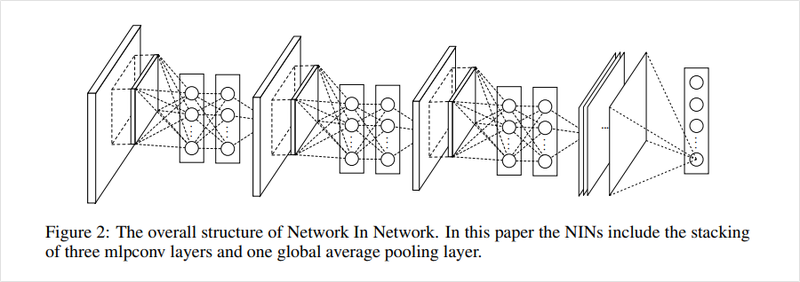 

### 2) CAM(Class Activation Map)
- 클래스가 활성화되는 지도. 
- 일반적인 CNN은 커널 윈도우에 따라 feature를 추출하므로 CNN 레이어를 거친 feature map에도 입력값의 위치 정보가 유지됨. 따라서 feature map의 정보를 이미지 detection이나 segmentation 등의 문제를 푸는 데 이용하기도 함.  
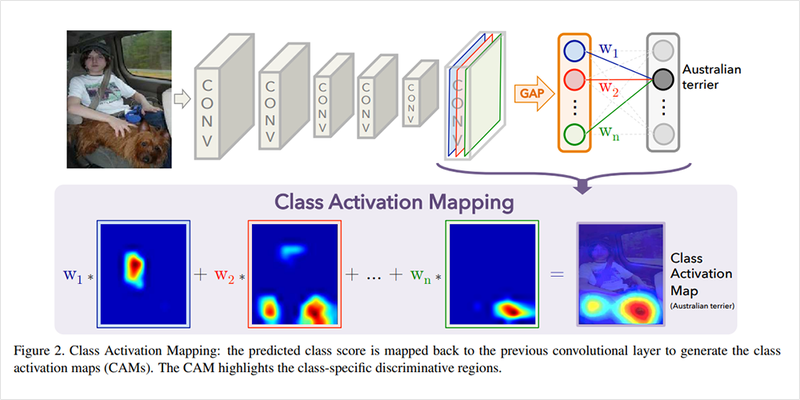

- CAM을 얻을 수 있는 네트워크는 위 그림에서 확인 가능함.
- 먼저 CNN 레이어를 거쳐 뽑아낸 feature map에서 GAP을 적용함. 그리고 이에 대해 소프트맥스 레이어(소프트맥스 활성화 함수를 갖고 bias가 없는 fc 레이어)를 적용함. 
- CNN을 거친 feature map에서 각 클래스에 대한 정보는 결과값의 여러 채널에 걸쳐 나타나고, GAP를 통해 각 채널별 정보를 요약하면 소프트맥스 레이어는 이 정보를 보고 각 클래스에 대한 개별 채널의 중요도를 결저함. **이렇게 클래스별로 소프트맥스 레이어를 통해 각 채널의 가중합을 구하면 각 클래스가 활성화 맵의 어떤 부분을 주로 활성화시키는지 확인할 수 있음. **
- 이렇게 얻은 feature map은 CNN의 출력값 크기와 같기에 이를 보간(interpolation)을 통해 적절히 원본 이미지 크기로 확대해주면 위와 같은 CAM을 얻을 수 있다고 함. (오...)


### 3) Grad-CAM
- 앞의 CAM은 활성화 맵을 얻기 위해 GAP을 사용해 $f_k$를 구하고, 그 뒤로 fc 레이어르르 추가로 붙여야 함. 또 가장 마지막 CNN 레이어의 결과물만을 시각화할 수 있음. 
- Grad-CAM은 CAM의 모델의 구조가 제한되는 문제를 해결하고, 다양한 모델의 구조를 해석할 수 있는 방법을 제안함. Grad-CAM을 사용하면 CNN 기반의 네트워크는 굳이 모델 구조를 변경할 필요가 없고 분류 문제 외의 다른 태스크들에 유연하게 대처할 수 있다고 함.

#### 그래디언트를 통한 Weight Score 계산
- CAM에서는 소프트맥스를 가진 fc 레이어의 가중치를 통해서 어떤 클래스에 대한 각 채널의 중요도 또는 가중치를 얻어냄. 
- Grad-CAM에서는 그래디언트를 사용함. 원하는 클래스에 대해서 관찰하는 레이어로 들어오는 그래디언트를 구할 수 있다면, 해당 클래스를 활성화할 때, 레이어의 특성 맵에서 어떤 채널이 중요하게 작용하는지 알 수 있음. 
- 활성화 맵에서 어떤 클래스의 위치에 따른 활성화를 보려면 어떻게 해야할까? Grad-CAM은 이를 위해서 k번째 활성화 맵과 이 가중치를 곱해 합한 뒤 ReLU 활성화 함수를 통해서 클래스에 따른 Grad-CAM을 얻는다. (ReLU를 사용해 활성화된 영역을 확인해야 하기 때문에 불필요한 음의 값을 줄일 수 있음)  
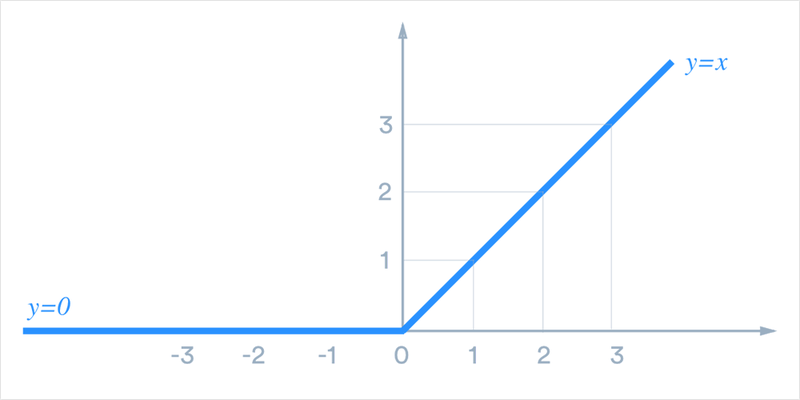

### 4) ACoL : Adversarial Complementary Learning
- CAM에서 신기한 점은 클래스와 이미지만을 데이터로 학습을 하는데 덤으로 위치 정보까지 얻을 수 있다는 점임. 
- 이처럼 직접적으로 정답 위치 정보를 주지 않아도 간접적인 정보를 활용해 학습하고 원하는 정보를 얻어낼 수 있도록 모델을 학습하는 방식을 약지도학습(weakly supervised learning)이라고 함. 
- CAM, Grad-CAM, ACoL은 약지도학습 기법을 활용해 물체 검출을 수행할 수 있음. 

#### (1) 약지도학습(weakly supervised learning)
- 약지도학습과 준지도학습(semi-supervised learning)이라는 단어를 혼용할 수 있음. 
- incomplete supervision : 학습 데이터 중 일부에만 라벨이 달린 경우, 이란적으로 말하는 준지도학습과 같은 경우임. 
- inexact supervision : 학습데이터의 라벨이 충분히 정확하게 달려있지 않은 경우 (예: 개나 고양이를 Object Detection 혹은 Semantic Segmentation해야 하지만 이미지 내에 정확한 boundiny box는 주어져 있지 않고 이미지가 개인지 고양인지 정보만 라벨로 달려있는 경우)
- inaccurate supervision : 학습 데이터에 Noise가 있는 경우 (예: 개나 고양이의 라벨이 잘못 달린 경우)

#### (2) Adversarial Complementary Learning
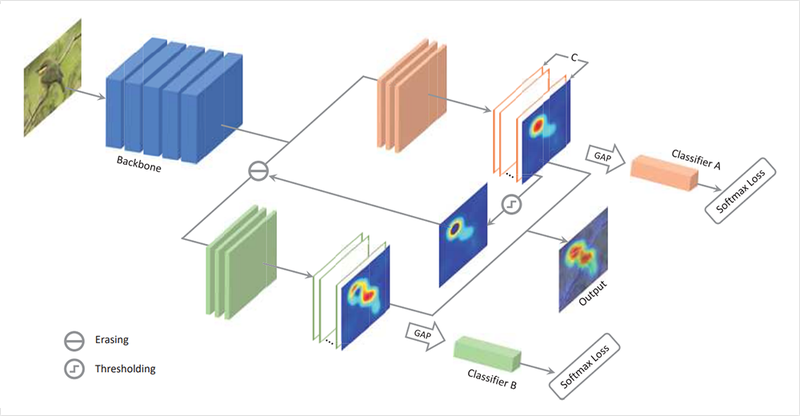

- ACoL은 모델의 학습에는 끝단이 두 브랜치로 나뉨. CAM을 만들기 위해 활용했던 feature map을 두 가지로 분리함. 
- CAM과 Grad-CAM은 약지도학습의 Object Detection, Segmentation의 가능성을 보여주었음. 그러나 이 방식에는 가장자리보다는 특징이 주로 나타나는 위치에 중점적으로 활성화된다는 문제가 있음. 
- Object detection은 물체의 전체적인 형태와 윤곽을 정확하게 구분해 내는 것이 중요함. CAM 모델이 특정 부위에 집중해 학습하는 것을 막기 위해 ACoL은 브랜치를 두 가지로 주어 너무 높은 점수를 지워줌으로써 주변의 특성 또한 반영하도록 함. 

#### (3) 1x1 Conv
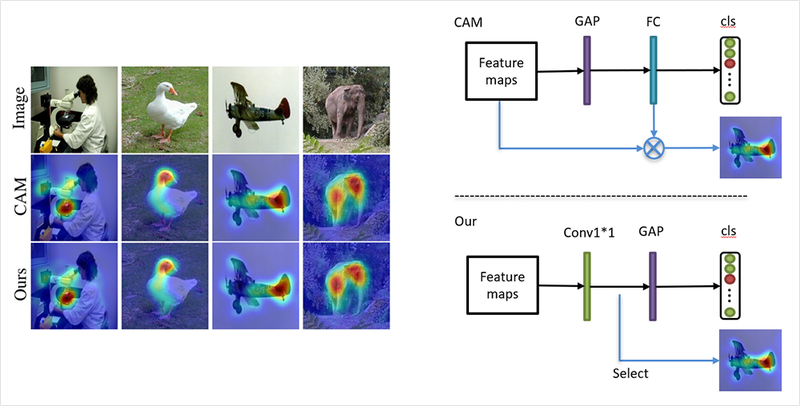

- CAM에서는 CAM을 얻기 위해서 대상이 되는 네트워크에 feed forward를 하고 활성화 맵과 가중치 계산을 다시 해주어야 함. 이 과정은 관찰하고자 하는 분류 모델의 feed forward와 별개의 작업이기에 물체 검출을 위한 모델을 사용하기 위해서는 모델의 feed forward 외 별도의 연산을 해주어야 하는 단점이 있음. 
- ACoL 논문은 이를 개선하기 위해 커널 사이즈는 1x1, 출력 채널의 개수는 분류하고자 하는 클래스 개수를 가진 컨볼루션 레이어를 특성 맵에 사용하고 여기에 GAP을 적용해 컨볼루션 레이어의 출력값이 곧바로 활성화 맵이 됨. 